In [ ]:
# !mkdir genres && wget http://opihi.cs.uvic.ca/sound/genres.tar.gz && tar -xf genres.tar.gz genres/

--2022-04-23 21:05:36--  http://opihi.cs.uvic.ca/sound/genres.tar.gz
Resolving opihi.cs.uvic.ca (opihi.cs.uvic.ca)... 142.104.68.135
Connecting to opihi.cs.uvic.ca (opihi.cs.uvic.ca)|142.104.68.135|:80... failed: Connection timed out.
Retrying.

--2022-04-23 21:07:46--  (try: 2)  http://opihi.cs.uvic.ca/sound/genres.tar.gz
Connecting to opihi.cs.uvic.ca (opihi.cs.uvic.ca)|142.104.68.135|:80... failed: Connection timed out.
Retrying.

--2022-04-23 21:09:58--  (try: 3)  http://opihi.cs.uvic.ca/sound/genres.tar.gz
Connecting to opihi.cs.uvic.ca (opihi.cs.uvic.ca)|142.104.68.135|:80... failed: Connection timed out.
Retrying.

--2022-04-23 21:12:10--  (try: 4)  http://opihi.cs.uvic.ca/sound/genres.tar.gz
Connecting to opihi.cs.uvic.ca (opihi.cs.uvic.ca)|142.104.68.135|:80... ^C


In [ ]:
# pip install torchaudio

In [1]:
import torch
import torchvision
import torchaudio
import random
import numpy as np
import librosa
import librosa.display
import pandas as pd
import os
from PIL import Image
import pathlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline
from tqdm.autonotebook import tqdm
import IPython.display as ipd
import torchvision.transforms as T

In [12]:
data_path = '/content/drive/MyDrive/GTZAN-dataset/Data/genres_original'

In [15]:
cmap = plt.get_cmap('inferno')
plt.figure(figsize=(8,8))
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
for g in genres:
    pathlib.Path(f'/content/drive/MyDrive/GTZAN-dataset/Data/img_data/{g}').mkdir(parents=True, exist_ok=True)
    for filename in os.listdir(f'{data_path}/{g}'):
        songname = f'{data_path}/{g}/{filename}'
        if '.ipynb' not in songname:
          y, sr = librosa.load(songname, mono=True, duration=5)
          plt.specgram(y, NFFT=2048, Fs=2, Fc=0, noverlap=128, cmap=cmap, sides='default', mode='default', scale='dB');
          plt.axis('off');
          plt.savefig(f'/content/drive/MyDrive/GTZAN-dataset/Data/img_data/{g}/{filename[:-3].replace(".", "")}.png')
          plt.clf()

/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_axes.py:7592: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


<Figure size 576x576 with 0 Axes>

In [16]:
img_path = '/content/drive/MyDrive/GTZAN-dataset/Data/img_data'

In [17]:
batch_size = 8
image_size = 224

In [18]:
train_trms = T.Compose([
                        T.Resize(image_size),
                        T.RandomRotation(20),
                        T.RandomHorizontalFlip(),
                        T.ToTensor()
                        ])
val_trms = T.Compose([
                        T.Resize(image_size),
                        T.ToTensor()
                        ])

In [19]:
train_data = torchvision.datasets.ImageFolder(root = img_path, transform = train_trms)
val_data = torchvision.datasets.ImageFolder(root = img_path, transform = val_trms)

In [20]:
def Encode(data):
    classes = data.classes
    encoder = {}
    for i in range(len(classes)):
        encoder[i] = classes[i]
    return encoder

def Decoder(data):
    classes = data.classes
    
    decoder = {}
    for i in range(len(classes)):
        decoder[classes[i]] = i
    return decoder

In [21]:
def class_plot(data,n_figures = 12):
    n_row = int(n_figures/4)
    fig,axes = plt.subplots(figsize=(14, 10), nrows = n_row, ncols=4)
    for ax in axes.flatten():
        a = random.randint(0,len(data))
        (image,label) = data[a]
#         print(type(image))
        label = int(label)
        encoder = Encode(data)
        l = encoder[label]
       
        image = image.numpy().transpose(1,2,0)
        im = ax.imshow(image)
        ax.set_title(l)
        ax.axis('off')
    plt.show()

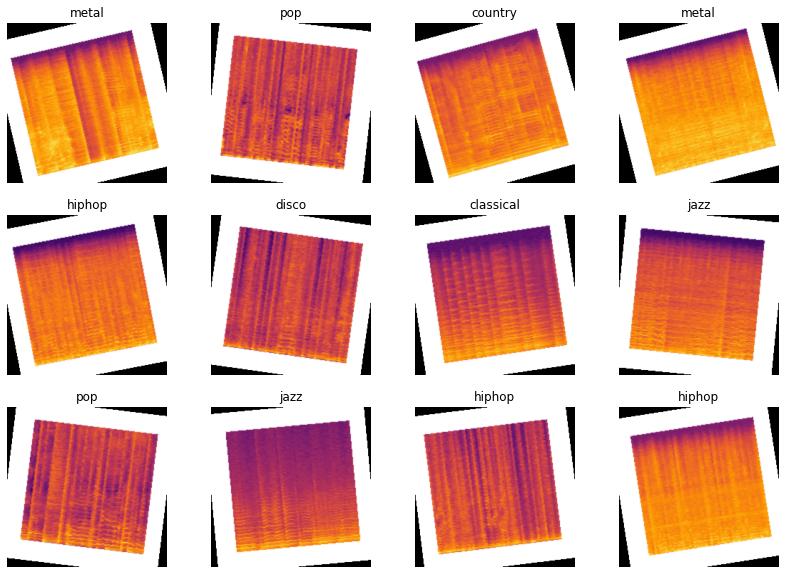

In [22]:
class_plot(train_data)

In [23]:
torch.manual_seed(43)
val_size = int(len(train_data)*0.1)
train_size = len(train_data) - val_size

In [24]:
from torch.utils.data import random_split
train_ds, val_ds = random_split(train_data, [train_size,val_size])
len(train_ds), len(val_ds)

(900, 99)

In [25]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


images.shape: torch.Size([8, 3, 224, 224])


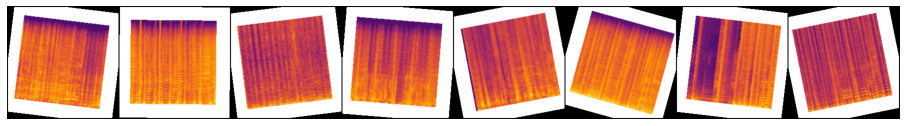

In [26]:
for images, _ in train_dl:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

In [2]:
def accuracy(outputs, labels):
  _,preds = torch.max(outputs,dim=1)
  return torch.tensor(torch.sum(preds == labels).item()/len(preds))

In [3]:
class MultilabelImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, targets = batch 
        out = self(images)                      
        loss = F.cross_entropy(out, targets)      
        return loss
    
    def validation_step(self, batch):
        images, targets = batch 
        out = self(images)                           # Generate predictions
        loss = F.cross_entropy(out, targets)  # Calculate loss
        score = accuracy(out, targets)
        return {'val_loss': loss.detach(), 'val_score': score.detach() }
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_scores = [x['val_score'] for x in outputs]
        epoch_score = torch.stack(batch_scores).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_score': epoch_score.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_score: {:.4f}".format(
            epoch, result['val_loss'], result['val_score']))
    
    def predict_output(self,image):
      return self(image)

In [4]:
class Net1(MultilabelImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1),

            nn.Flatten(), 
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
            
        )
        
    def forward(self, xb):
        return self.network(xb)

In [5]:
import torchvision.models as models
class Net(MultilabelImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet34(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 10)
    
    def forward(self, xb):
        return self.network(xb)
    def freeze(self):
      for param in self.network.parameters():
        param.require_grad = False
      for param in self.network.fc.parameters():
        param.require_grad = True
    
    def unfreeze(self):
      for param in self.network.parameters():
        param.require_grad = True

In [6]:
Net()

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

Net(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running

In [7]:
def evaluate(model,val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [8]:
@torch.no_grad()
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            loss.backward()
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            optimizer.step()
            optimizer.zero_grad()
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        # Validation phase
        result = evaluate(model, val_loader)
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [9]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [10]:
device = get_default_device()
device

device(type='cuda')

In [11]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

NameError: ignored

In [12]:
model = to_device(Net(), device)

In [38]:
torch.cuda.empty_cache()

In [39]:
history = [evaluate(model, val_dl)]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [40]:
model.freeze()

In [41]:
epochs = 5
max_lr = 0.001
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [42]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

  0%|          | 0/113 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], val_loss: 2.2029, val_score: 0.2054


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [1], val_loss: 1.9490, val_score: 0.2321


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [2], val_loss: 1.8758, val_score: 0.2589


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [3], val_loss: 1.5542, val_score: 0.4315


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [4], val_loss: 1.5891, val_score: 0.3750
CPU times: user 1min 18s, sys: 31.9 s, total: 1min 50s
Wall time: 2min 19s


In [43]:
%%time
history += fit_one_cycle(15, max_lr, model, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

  0%|          | 0/113 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], val_loss: 1.5673, val_score: 0.4107


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [1], val_loss: 1.8462, val_score: 0.3482


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [2], val_loss: 1.6526, val_score: 0.3571


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [3], val_loss: 1.6313, val_score: 0.4405


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [4], val_loss: 1.6221, val_score: 0.4048


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [5], val_loss: 1.6100, val_score: 0.4137


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [6], val_loss: 1.7228, val_score: 0.4048


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [7], val_loss: 1.3814, val_score: 0.5298


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [8], val_loss: 1.4023, val_score: 0.4643


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [9], val_loss: 1.5542, val_score: 0.4643


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [10], val_loss: 1.3643, val_score: 0.5565


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [11], val_loss: 1.2265, val_score: 0.6101


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [12], val_loss: 1.2644, val_score: 0.5655


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [13], val_loss: 1.2694, val_score: 0.5655


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [14], val_loss: 1.2526, val_score: 0.6012
CPU times: user 3min 58s, sys: 1min 35s, total: 5min 34s
Wall time: 6min 57s


In [44]:
model.unfreeze()

In [45]:
%%time
history += fit_one_cycle(50, max_lr, model, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

  0%|          | 0/113 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], val_loss: 1.2407, val_score: 0.5565


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [1], val_loss: 1.2369, val_score: 0.6101


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [2], val_loss: 1.3477, val_score: 0.5833


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [3], val_loss: 1.3260, val_score: 0.5923


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [4], val_loss: 1.3761, val_score: 0.5833


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [5], val_loss: 1.4950, val_score: 0.5744


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [6], val_loss: 1.3634, val_score: 0.5208


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [7], val_loss: 1.2435, val_score: 0.5655


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [8], val_loss: 1.4390, val_score: 0.5387


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [9], val_loss: 1.4411, val_score: 0.5208


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [10], val_loss: 1.4111, val_score: 0.5387


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [11], val_loss: 1.3302, val_score: 0.5208


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [12], val_loss: 1.3402, val_score: 0.5565


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [13], val_loss: 1.4569, val_score: 0.5744


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [14], val_loss: 1.4037, val_score: 0.5298


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [15], val_loss: 1.4941, val_score: 0.5030


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [16], val_loss: 1.2434, val_score: 0.5833


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [17], val_loss: 1.3919, val_score: 0.5268


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [18], val_loss: 1.3975, val_score: 0.5208


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [19], val_loss: 1.2298, val_score: 0.6488


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [20], val_loss: 1.2416, val_score: 0.6012


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [21], val_loss: 1.3108, val_score: 0.5923


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [22], val_loss: 1.4748, val_score: 0.5387


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [23], val_loss: 1.1956, val_score: 0.6131


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [24], val_loss: 1.6125, val_score: 0.4911


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [25], val_loss: 1.5419, val_score: 0.5357


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [26], val_loss: 1.1953, val_score: 0.6369


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [27], val_loss: 1.5713, val_score: 0.5387


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [28], val_loss: 1.6648, val_score: 0.5387


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [29], val_loss: 1.6861, val_score: 0.5208


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [30], val_loss: 1.8533, val_score: 0.5089


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [31], val_loss: 1.6195, val_score: 0.5565


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [32], val_loss: 1.4048, val_score: 0.5833


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [33], val_loss: 1.4780, val_score: 0.5655


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [34], val_loss: 1.5913, val_score: 0.6012


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [35], val_loss: 1.8105, val_score: 0.5923


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [36], val_loss: 1.8424, val_score: 0.5923


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [37], val_loss: 1.7301, val_score: 0.6101


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [38], val_loss: 1.7022, val_score: 0.6548


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [39], val_loss: 1.8381, val_score: 0.5744


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [40], val_loss: 1.8382, val_score: 0.6012


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [41], val_loss: 1.6759, val_score: 0.6637


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [42], val_loss: 1.6648, val_score: 0.6101


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [43], val_loss: 1.9905, val_score: 0.6190


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [44], val_loss: 1.8913, val_score: 0.6101


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [45], val_loss: 2.0072, val_score: 0.6458


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [46], val_loss: 1.9004, val_score: 0.6280


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [47], val_loss: 1.7668, val_score: 0.6667


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [48], val_loss: 1.9852, val_score: 0.6280


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [49], val_loss: 2.0586, val_score: 0.5923
CPU times: user 13min 3s, sys: 5min 7s, total: 18min 10s
Wall time: 23min 11s


In [ ]:
%%time
history += fit_one_cycle(100, max_lr, model, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

  0%|          | 0/113 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], val_loss: 1.6670, val_score: 0.5923


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [1], val_loss: 1.9506, val_score: 0.6101


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [2], val_loss: 2.1797, val_score: 0.5833


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [3], val_loss: 1.7605, val_score: 0.6458


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [4], val_loss: 2.2241, val_score: 0.6012


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [5], val_loss: 1.9034, val_score: 0.6190


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [6], val_loss: 1.9267, val_score: 0.5923


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [7], val_loss: 2.2224, val_score: 0.5565


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [8], val_loss: 1.9991, val_score: 0.6190


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [9], val_loss: 1.8397, val_score: 0.6190


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [10], val_loss: 2.3517, val_score: 0.5923


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [11], val_loss: 1.6876, val_score: 0.6845


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [12], val_loss: 2.2036, val_score: 0.5298


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [13], val_loss: 1.5346, val_score: 0.6310


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [14], val_loss: 1.9186, val_score: 0.5298


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [15], val_loss: 1.5298, val_score: 0.6101


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [16], val_loss: 1.6675, val_score: 0.5655


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [17], val_loss: 2.1112, val_score: 0.5833


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [18], val_loss: 1.5298, val_score: 0.6101


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [19], val_loss: 1.4883, val_score: 0.5833


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [20], val_loss: 1.8502, val_score: 0.5833


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [21], val_loss: 1.8365, val_score: 0.6012


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [22], val_loss: 2.2915, val_score: 0.5208


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [23], val_loss: 1.7737, val_score: 0.5565


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [24], val_loss: 1.6894, val_score: 0.6190


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [25], val_loss: 1.6473, val_score: 0.5565


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [26], val_loss: 1.4534, val_score: 0.6399


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [27], val_loss: 1.8162, val_score: 0.5387


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [28], val_loss: 2.4052, val_score: 0.5476


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [29], val_loss: 1.8011, val_score: 0.5476


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [30], val_loss: 1.6681, val_score: 0.5833


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [31], val_loss: 1.9625, val_score: 0.5833


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [32], val_loss: 2.2182, val_score: 0.5208


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [33], val_loss: 1.9023, val_score: 0.5833


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [34], val_loss: 2.1066, val_score: 0.5030


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [35], val_loss: 1.9376, val_score: 0.5833


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [36], val_loss: 1.9462, val_score: 0.5923


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [37], val_loss: 1.6498, val_score: 0.6012


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [38], val_loss: 1.6615, val_score: 0.6012


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [39], val_loss: 1.8472, val_score: 0.5655


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [40], val_loss: 1.7345, val_score: 0.6042


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [41], val_loss: 2.0892, val_score: 0.5923


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [42], val_loss: 1.7651, val_score: 0.5298


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [43], val_loss: 2.0536, val_score: 0.5565


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [44], val_loss: 1.5327, val_score: 0.6012


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [45], val_loss: 2.1207, val_score: 0.5387


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [46], val_loss: 1.6055, val_score: 0.6310


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [47], val_loss: 2.1987, val_score: 0.5119


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [48], val_loss: 1.7100, val_score: 0.6488


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [49], val_loss: 2.1991, val_score: 0.5744


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [50], val_loss: 2.1781, val_score: 0.5387


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [51], val_loss: 1.9706, val_score: 0.4821


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [52], val_loss: 2.0868, val_score: 0.6310


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [53], val_loss: 2.2566, val_score: 0.5565


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [54], val_loss: 1.8367, val_score: 0.5952


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [55], val_loss: 1.6857, val_score: 0.6756


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [56], val_loss: 2.1873, val_score: 0.5476


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [57], val_loss: 1.9901, val_score: 0.5833


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [58], val_loss: 2.3018, val_score: 0.5655


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [59], val_loss: 2.2437, val_score: 0.5536


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [60], val_loss: 1.5885, val_score: 0.6310


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [61], val_loss: 2.2996, val_score: 0.5923


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [62], val_loss: 2.0174, val_score: 0.5744


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [63], val_loss: 2.1354, val_score: 0.6012


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [64], val_loss: 2.2138, val_score: 0.6012


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [65], val_loss: 2.0707, val_score: 0.5744


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [66], val_loss: 1.7177, val_score: 0.6280


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [67], val_loss: 1.7867, val_score: 0.6488


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [68], val_loss: 1.9753, val_score: 0.6190


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [69], val_loss: 1.7319, val_score: 0.6667


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [70], val_loss: 2.2054, val_score: 0.5298


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [71], val_loss: 2.1123, val_score: 0.6667


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [72], val_loss: 2.1477, val_score: 0.6131


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [73], val_loss: 2.2144, val_score: 0.6310


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [74], val_loss: 2.2198, val_score: 0.5565


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [75], val_loss: 2.1864, val_score: 0.5923


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [76], val_loss: 1.9866, val_score: 0.6399


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [77], val_loss: 1.9791, val_score: 0.6756


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [78], val_loss: 2.0579, val_score: 0.6488


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [79], val_loss: 2.2499, val_score: 0.6131


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [80], val_loss: 2.1320, val_score: 0.6488


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [81], val_loss: 2.0879, val_score: 0.6131


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [82], val_loss: 1.8590, val_score: 0.6756


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [83], val_loss: 1.9924, val_score: 0.6667


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [84], val_loss: 2.0369, val_score: 0.6399


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [85], val_loss: 2.1596, val_score: 0.6310


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [86], val_loss: 2.0319, val_score: 0.6399


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [87], val_loss: 1.9006, val_score: 0.6399


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [88], val_loss: 2.0054, val_score: 0.6667


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [89], val_loss: 2.1805, val_score: 0.6399


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [90], val_loss: 1.8571, val_score: 0.6012


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [91], val_loss: 1.9605, val_score: 0.6845


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [92], val_loss: 2.0983, val_score: 0.5655


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [93], val_loss: 2.0335, val_score: 0.6399


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [94], val_loss: 2.0033, val_score: 0.5744


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [95], val_loss: 2.0703, val_score: 0.6399


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [96], val_loss: 2.0126, val_score: 0.6399


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [97], val_loss: 2.0790, val_score: 0.6577


  0%|          | 0/113 [00:00<?, ?it/s]

In [ ]:
torch.save(model.state_dict(), '/content/model.pth')

In [13]:
model.load_state_dict(torch.load('./model.pth', map_location=device), strict=False)

<All keys matched successfully>

In [19]:
test_img_path = '/content/test'

In [24]:
test_img = torchvision.datasets.ImageFolder(root = test_img_path)

FileNotFoundError: ignored